# Check ESSP Indicator Results
1. Plot all time series
1. Plot against DRP values where available
1. Plot pairwise plots

In [1]:
# Generate Data Set with Given Parameters
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from astropy.io import fits
from astropy.time import Time
import pandas as pd
from tqdm import tqdm

import sys
sys.path.append('../')
from utils import *

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

In [2]:
essp_dir = 'neidMask_wtd'

In [3]:
col_list = ['CCF FWHM [km/s]','CCF FWHM Err. [km/s]',
            'CCF Contrast','CCF Contrast Err.',
            'BIS [m/s]','H-alpha Emission','S Index']
num_col = len(col_list)

cols_drp = ['fwhm','e_fwhm','contrast','e_contrast','bis','halpha','caHK']
cols_dict = dict(zip(col_list,cols_drp))

inst2file = lambda inst : os.path.join(solar_dir,'UniformInds',f'{inst}_inds_{essp_dir}.csv')
inst_dict = {inst:pd.read_csv(inst2file(inst)) for inst in instruments}
inst_dict['expres'] = inst_dict['expres'].rename(columns={'Time [MJD]':'mjd'})

## Time Series

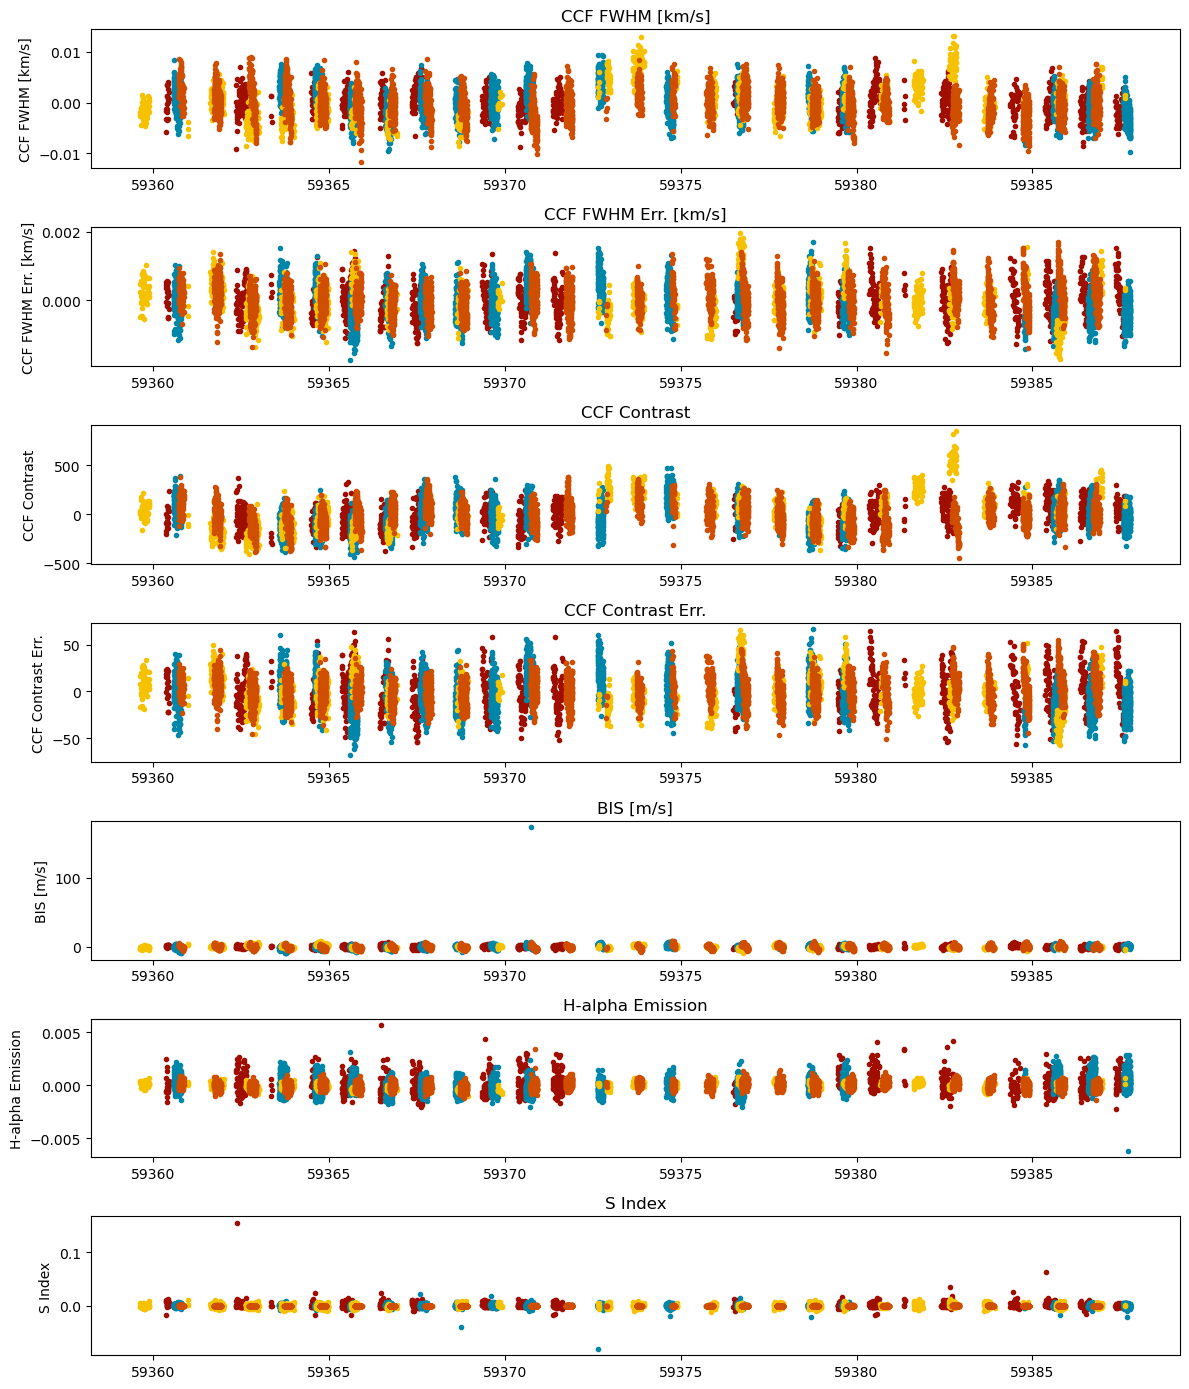

In [4]:
fig, axes = plt.subplots(num_col,1,figsize=(12,num_col*2))
for iinst, inst in enumerate(instruments):
    inst_df = inst_dict[inst]
    for iind,ind in enumerate(col_list):
        ax = axes[iind]
        drp_ind = cols_dict[ind]
        if ind not in inst_df.columns:
            continue
        ax.plot(inst_df['mjd'],inst_df[ind]-np.nanmedian(inst_df[ind]),'.',color=inst_cols[iinst])
for iind, ind in enumerate(col_list):
    axes[iind].set_title(ind)
    axes[iind].set_ylabel(ind)
fig.tight_layout()
fig.savefig(f'/mnt/home/lzhao/SolarComparison/Figures/ut3_inds_{essp_dir}.png')

## Empirical Errors

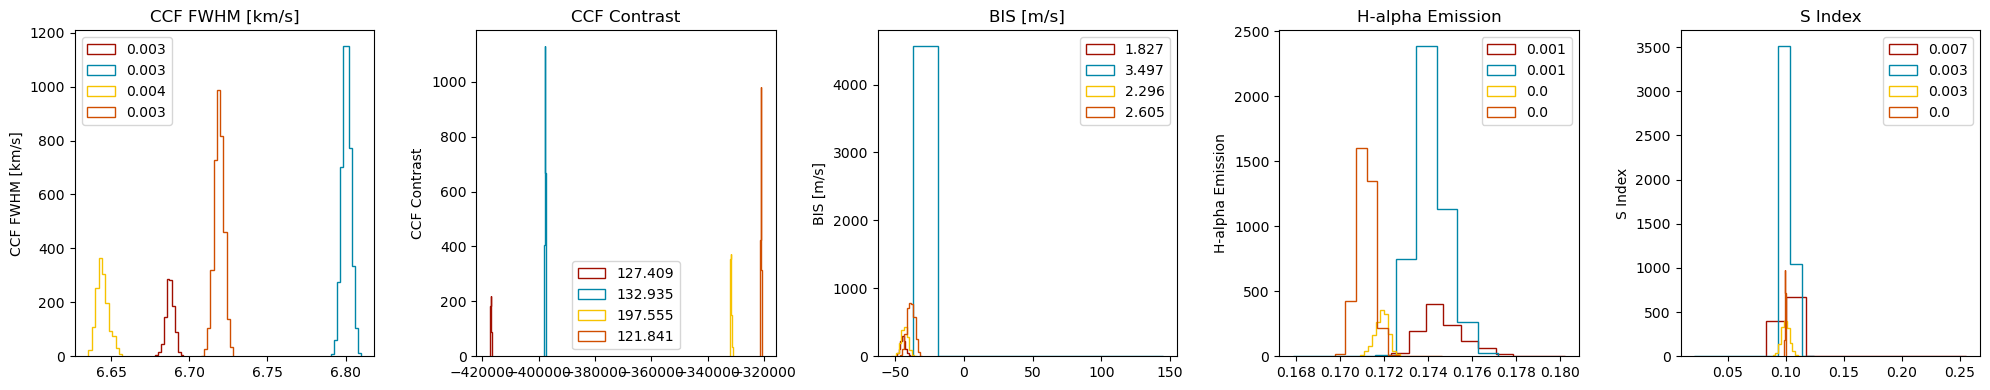

In [5]:
err_list = ['CCF FWHM [km/s]','CCF Contrast','BIS [m/s]','H-alpha Emission','S Index']
fig, axes = plt.subplots(1,len(err_list),figsize=(len(err_list)*4,4))
for iinst, inst in enumerate(instruments):
    inst_df = inst_dict[inst]
    for iind,ind in enumerate(err_list):
        ax = axes[iind]
        drp_ind = cols_dict[ind]
        if ind not in inst_df.columns:
            continue
        ax.hist(inst_df[ind],color=inst_cols[iinst],
                histtype='step',label=np.round(np.std(inst_df[ind]),3))
for iind, ind in enumerate(err_list):
    axes[iind].set_title(ind)
    axes[iind].set_ylabel(ind)
    axes[iind].legend()
fig.tight_layout()
fig.savefig(f'/mnt/home/lzhao/SolarComparison/Figures/ut3_inds_errors_{essp_dir}.png')

## Compare Against DRP Values

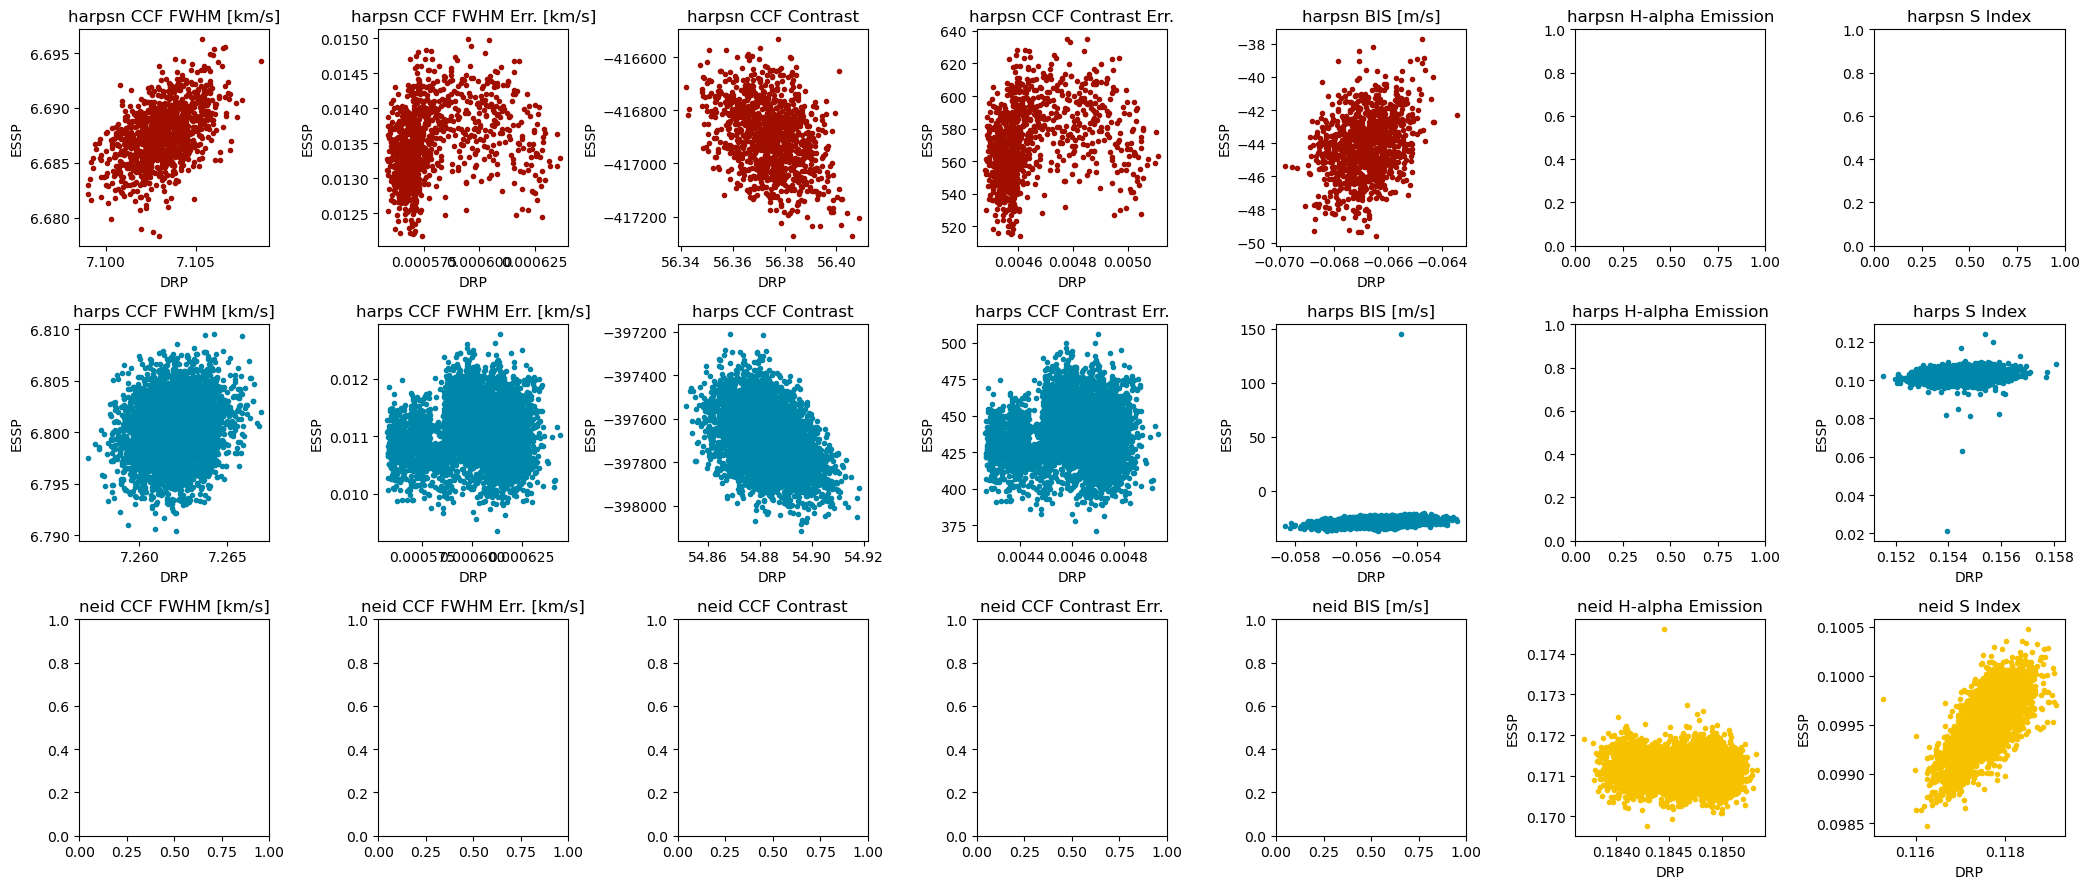

In [6]:
fig, axes = plt.subplots(3,len(col_list),
                         figsize=(len(col_list)*3,3*3))
for iinst, inst in enumerate(['harpsn','harps','neid']):
    inst_df = inst_dict[inst]
    for iind,ind in enumerate(col_list):
        ax = axes[iinst,iind]
        ax.set_title(f'{inst} {ind}')
        drp_ind = cols_dict[ind]
        if ind not in inst_df.columns or drp_ind not in inst_df.columns:
            continue
        
        ax.set_xlabel('DRP')
        ax.set_ylabel('ESSP')
        ax.plot(inst_df[drp_ind],inst_df[ind],'.',color=inst_cols[iinst])
fig.tight_layout()
fig.savefig(f'/mnt/home/lzhao/SolarComparison/Figures/ut3_indsVdrp_{essp_dir}.png')

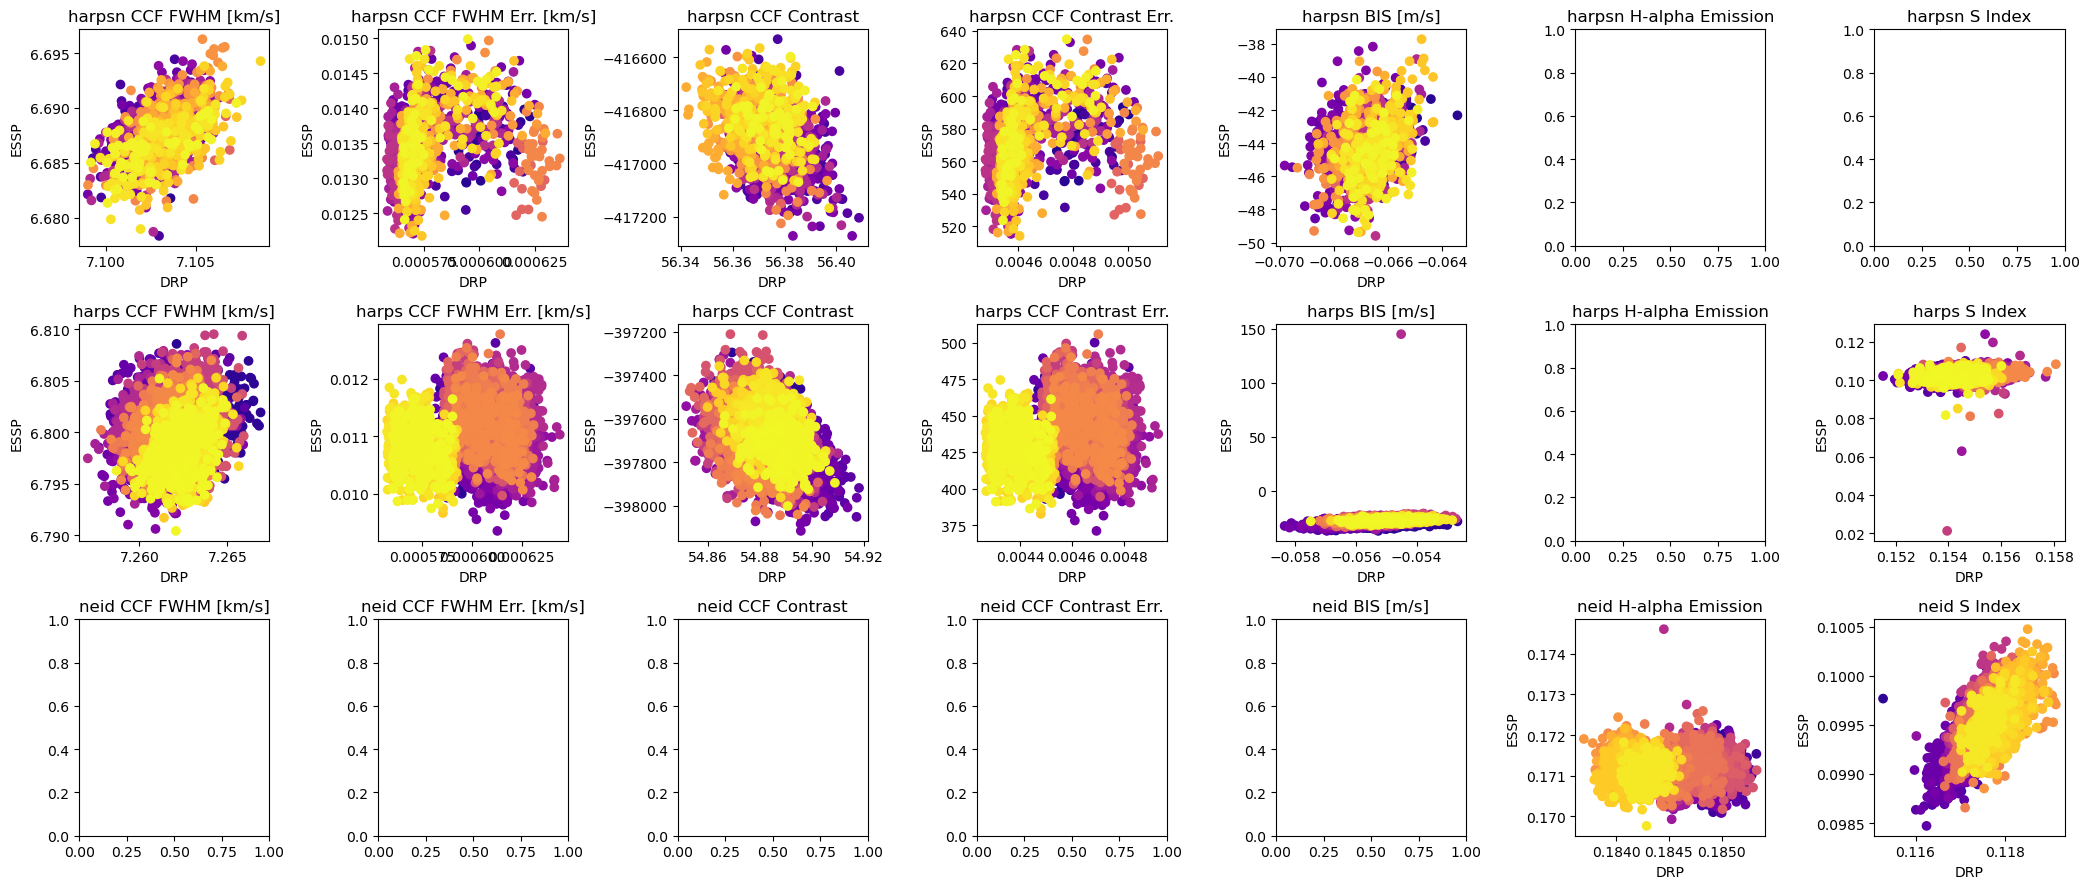

In [7]:
fig, axes = plt.subplots(3,len(col_list),
                         figsize=(len(col_list)*3,3*3))
for iinst, inst in enumerate(['harpsn','harps','neid']):
    inst_df = inst_dict[inst]
    for iind,ind in enumerate(col_list):
        ax = axes[iinst,iind]
        ax.set_title(f'{inst} {ind}')
        drp_ind = cols_dict[ind]
        if ind not in inst_df.columns or drp_ind not in inst_df.columns:
            continue
        
        ax.set_xlabel('DRP')
        ax.set_ylabel('ESSP')
        ax.scatter(inst_df[drp_ind],inst_df[ind],c=inst_df['mjd'],
                   cmap='plasma',vmin=mon_min,vmax=mon_max)
fig.tight_layout()
fig.savefig(f'/mnt/home/lzhao/SolarComparison/Figures/ut3_indsVdrpWtime_{essp_dir}.png')

## Pairwise Plots

### Binning

In [8]:
def timeSmooth_linear(tarr,time,yarr,yerr=None,twid=1/24/60*5/2):
    # interpolation done by weighted average
    # weight falls off linearly with time
    yint, eint = np.full((2,len(tarr)),np.nan)
    for it,t in enumerate(tarr):
        if np.sum(np.logical_and(time>(t-twid*1.5),time<(t+twid*1.5)))<3:
            continue
        time_w = abs(time-t)+np.min(np.diff(time)) # linear weighting away from time
        m = abs(time-t)<(twid*1.5)
        if np.sum(m)==0:
            continue
        weights = (time_w/yerr**2)[m] if yerr is not None else None
        yint[it] = np.average(yarr[m],weights=weights)
    return yint

In [9]:
bins5 = np.loadtxt('/mnt/home/lzhao/SolarComparison/SmallData/220928_bins5min.csv')

In [10]:
bind_dict = {}
for icol,col in enumerate(tqdm(col_list)):
    bind_dict[col] = {'time':bins5}
    for iinst,inst in enumerate(instruments):
        time, yarr = inst_dict[inst][['mjd',col]].to_numpy().T
        if col == 'CCF FWHM [km/s]':
            yerr = inst_dict[inst]['CCF FWHM Err. [km/s]'].to_numpy()
        elif col == 'CCF Contrast':
            yerr = inst_dict[inst]['CCF Contrast Err.'].to_numpy()
        else:
            yerr = None
        bind_dict[col][inst] = timeSmooth_linear(bins5,time,yarr,yerr,twid=1/24/60*5)

100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


### Plotting

In [11]:
dint_list = Time(['2021-05-31','2021-06-20']).mjd.astype(int)
dint = dint_list[0]
bin_dint_mask = bins5.astype(int)==dint

def offsetPlot(col):
    fig = plt.figure(figsize=(15,5))
    axes = []
    gs = GridSpec(2,6)
    
    ax1 = fig.add_subplot(gs[0,:3]) # Plot Full Time Series
    ax1.set_xlabel('Time [MJD]')
    ax2 = fig.add_subplot(gs[0,3:]) # Plot May 31
    ax2.set_xlabel('May 31 ToD [Hr]')
    axes.append(ax1)
    axes.append(ax2)
    for ax in axes:
        ax.set_ylabel(col)
    for iinst,inst in enumerate(instruments):
        inst_df = inst_dict[inst]
        dint_mask = inst_df['mjd'].astype(int)==dint
        
        y = inst_df[col].to_numpy()
        y[abs(y-np.nanmean(y))>(3*np.nanstd(y))] = np.nan
        ymed = np.nanmedian(y[dint_mask])
        
        ax1.plot(inst_df['mjd'],y-ymed,'.',alpha=0.5,color=inst_cols[iinst])
        ax2.plot((inst_df['mjd'][dint_mask]-dint)*24,inst_df[col][dint_mask]-ymed,'.',
                 alpha=0.2,color=inst_cols[iinst])
        
        ax2.plot((bind_dict[col]['time'][bin_dint_mask]-dint)*24,
                 bind_dict[col][inst][bin_dint_mask]-ymed,'.',color=inst_cols[iinst])
    ax1.axvline(dint,color='k')

    # Plot Correlations
    npair = 0
    for iinst,inst in enumerate(instruments):
        for jinst,jnst in enumerate(instruments[iinst+1:]):
            ax = fig.add_subplot(gs[1,npair])
            axes.append(ax)
            npair += 1
            ax.set_title(f'{jnst} v {inst}')
            ax.set_ylabel(jnst)
            ax.set_xlabel(inst)

            x,y = bind_dict[col][inst],bind_dict[col][jnst]
            ax.scatter(x,y,c=bind_dict[col]['time'],cmap='plasma',
                       s=3,vmin=mon_min,vmax=mon_max)
            
            xlim = ax.get_xlim()
            m = np.isfinite(x)&np.isfinite(y)
            if np.sum(m)==0:
                continue
            pfit = np.polyfit(x[m],y[m],1)
            p = np.poly1d(pfit)
            ax.plot(xlim,p(xlim),'k')
            ax.set_xlim(*xlim)
            
            ax.text(0.5,0.95,'{:.3}x+{:.3}'.format(*pfit),fontsize=14,
                    ha='center',va='top',transform=ax.transAxes)
    fig.tight_layout()
    return fig, axes

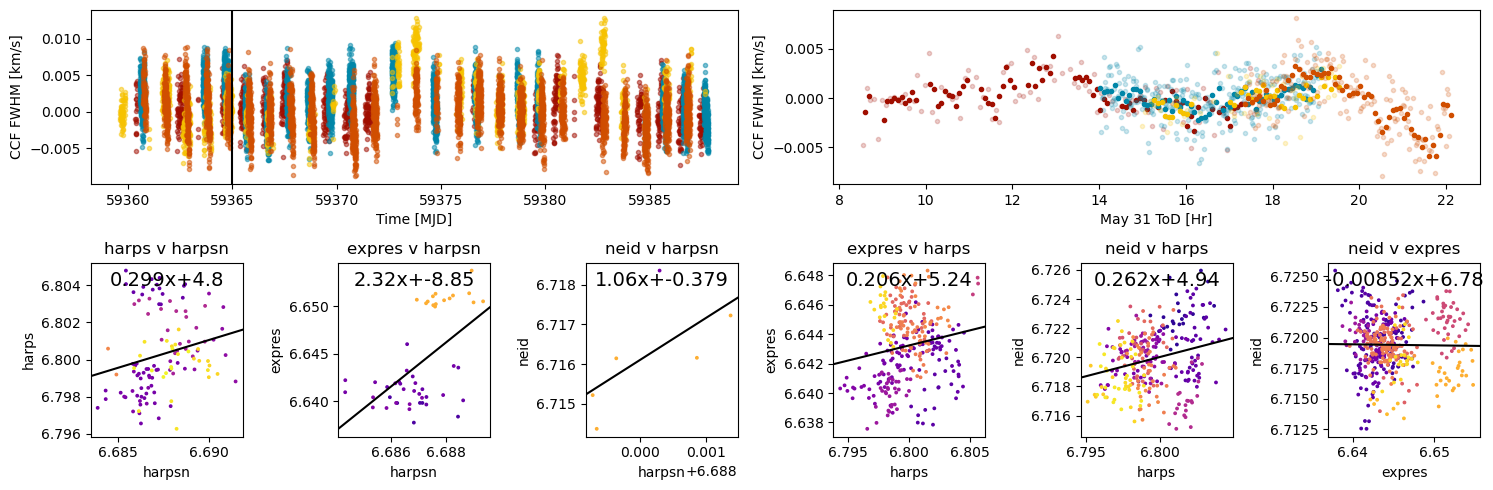

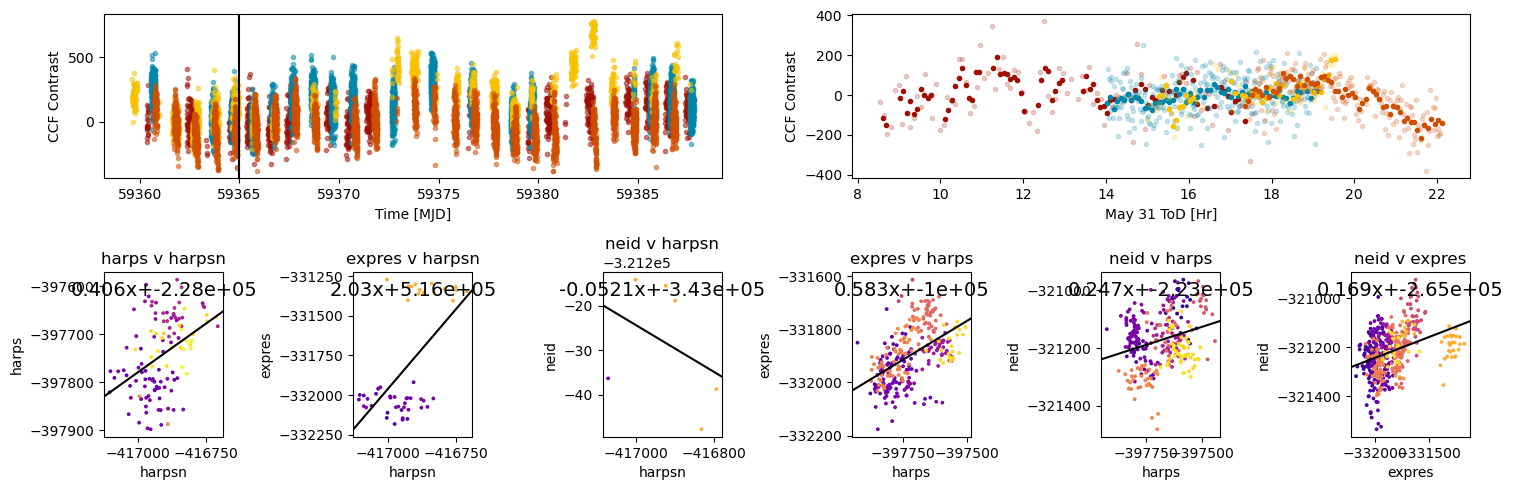

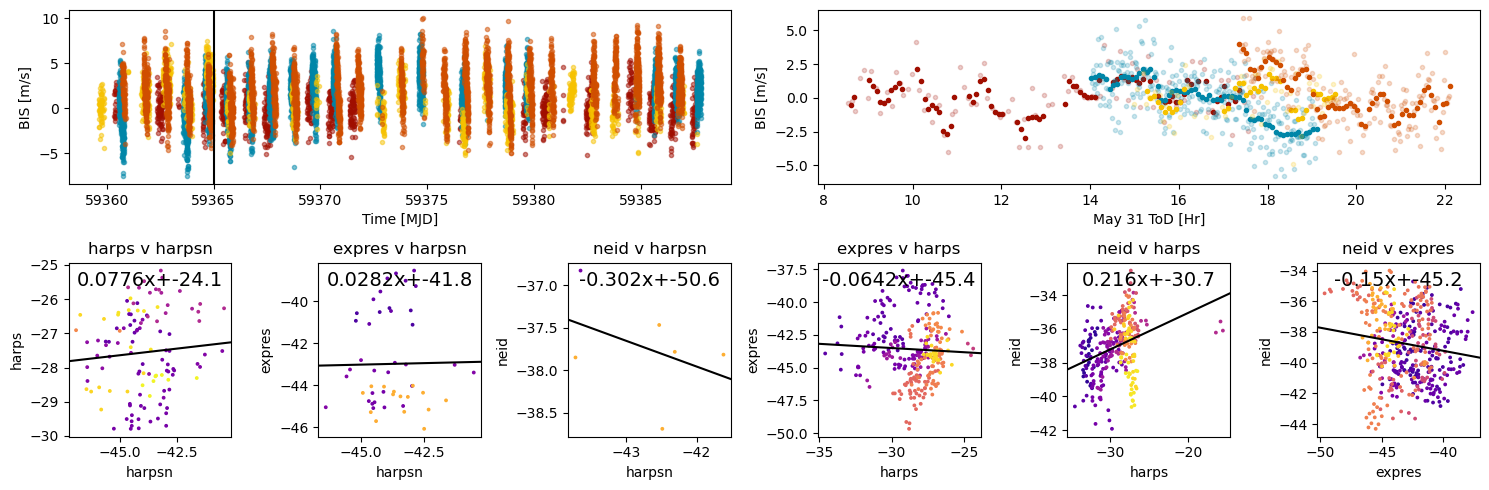

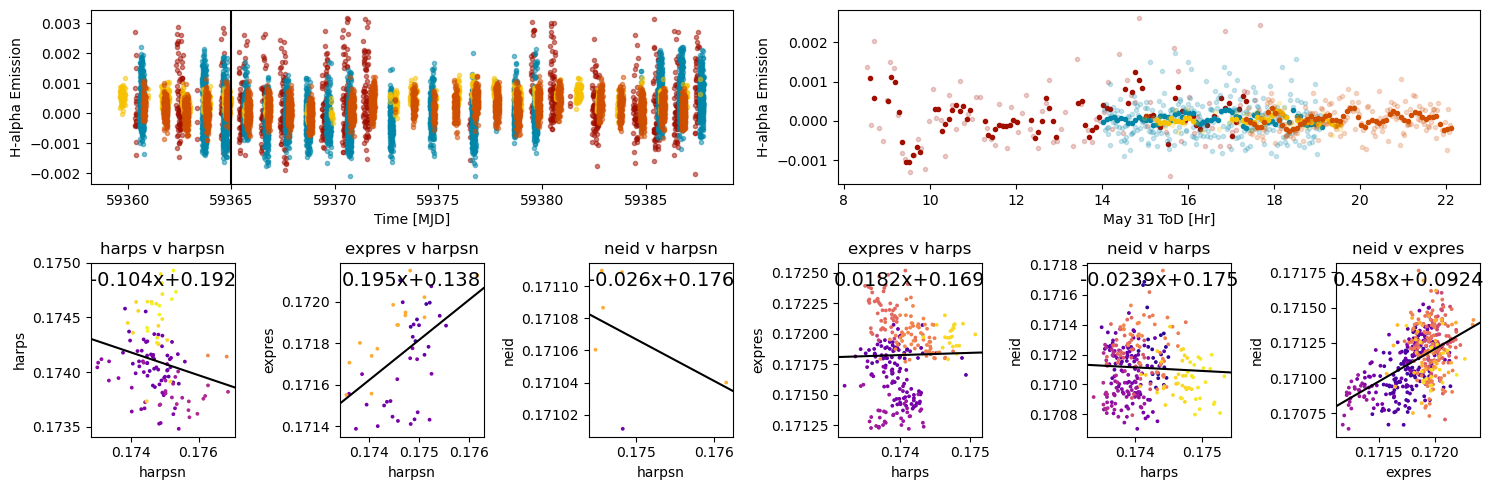

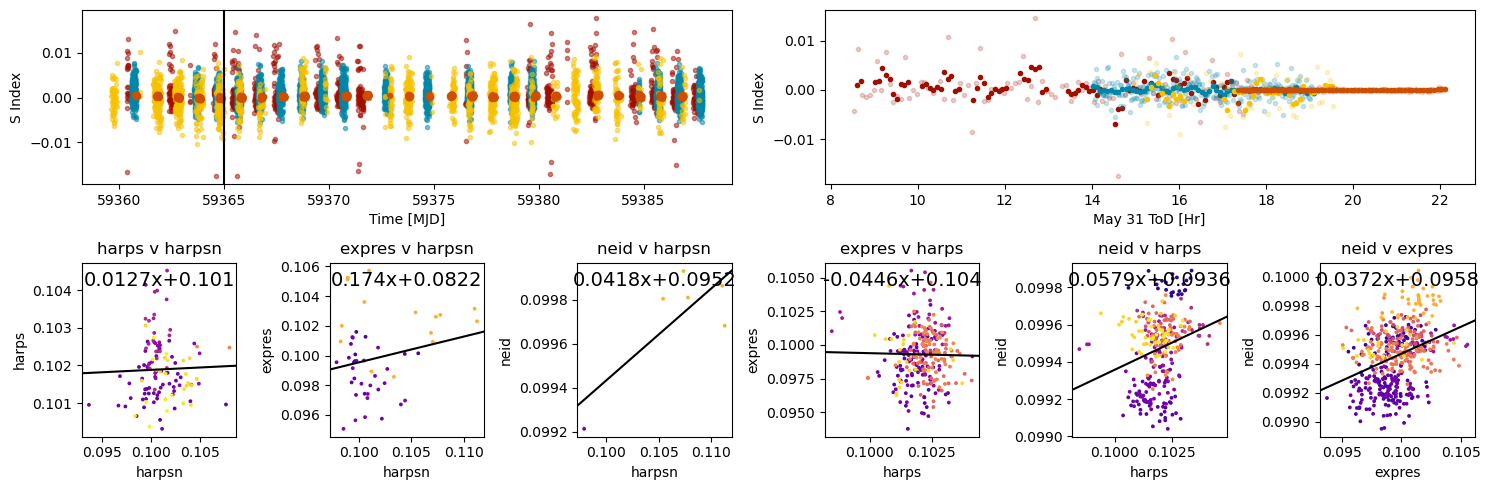

In [12]:
cols4plot = ['CCF FWHM [km/s]','CCF Contrast',
             'BIS [m/s]','H-alpha Emission','S Index']
col_names = ['fwhm','contrast','bis','halpha','caII']
for icol,col in enumerate(cols4plot):
    fig, axes = offsetPlot(col)
    fig.savefig(f'/mnt/home/lzhao/SolarComparison/Figures/ut3_{col_names[icol]}_{essp_dir}.png')